# Merge testis all replicates

In [1]:
options(repr.plot.width=10, repr.plot.height=10)
source('../lib/seurat.R')
library(Seurat)
library(dplyr)
library(Matrix)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
DATA_DIR <- '../output/testis_cell_selection'
OUTDIR <- '../output/combined_testis_bulk'
REFERENCES_DIR <- Sys.getenv('REFERENCES_DIR')

# Get list of mitochondiral genes
fbgn2chrom <- read.table('../output/fbgn2chrom.tsv', header=T)
fbgn2symbol <- read.csv(file.path(REFERENCES_DIR, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'), header=T, sep = '\t')[, c('gene_symbol', 'primary_FBgn')]
mito <- fbgn2chrom[fbgn2chrom$chrom == 'chrM', 'FBgn']

In [3]:
dat <- read.table(file.path(DATA_DIR, '01.01-testis_cell_selection_testis1_raw_counts.tsv') , header=TRUE, row.names='FBgn')
colnames(dat) <- paste0('rep1_', colnames(dat))
r1 <- CreateSeuratObject(raw.data = dat, min.cells = 3, project = 'Testis1BulkCombined')
r1@meta.data$rep <- 'rep1'
r1 <- FilterCells(object = r1, subset.names = c("nGene"), low.thresholds = c(200), high.thresholds = c(6000))
r1 <- NormalizeData(object = r1, normalization.method = "LogNormalize", scale.factor = 1e4)
r1 <- ScaleData(object = r1, vars.to.regress = c("nUMI"), display.progress = FALSE)

In [4]:
# Load the 10x dataset Rep 2
dat <- read.table(file.path(DATA_DIR, '01.01-testis_cell_selection_testis2_raw_counts.tsv') , header=TRUE, row.names='FBgn')
colnames(dat) <- paste0('rep2_', colnames(dat))
r2 <- CreateSeuratObject(raw.data = dat, min.cells = 3, min.genes = 200, project = 'Testis2BulkCombined')
r2@meta.data$rep <- 'rep2'
r2 <- FilterCells(object = r2, subset.names = c("nGene"), low.thresholds = c(200), high.thresholds = c(6000))
r2 <- NormalizeData(object = r2, normalization.method = "LogNormalize", scale.factor = 1e4)
r2 <- ScaleData(object = r2, vars.to.regress = c("nUMI"), display.progress = FALSE)

In [5]:
# Load the 10x dataset Rep 3
dat <- read.table(file.path(DATA_DIR, '01.01-testis_cell_selection_testis3_raw_counts.tsv') , header=TRUE, row.names='FBgn')
colnames(dat) <- paste0('rep3_', colnames(dat))
r3 <- CreateSeuratObject(raw.data = dat, min.cells = 3, min.genes = 200, project = 'Testis3BulkCombined')
r3@meta.data$rep <- 'rep3'
r3 <- FilterCells(object = r3, subset.names = c("nGene"), low.thresholds = c(200), high.thresholds = c(6000))
r3 <- NormalizeData(object = r3, normalization.method = "LogNormalize", scale.factor = 1e4)
r3 <- ScaleData(object = r3, vars.to.regress = c("nUMI"), display.progress = FALSE)

In [6]:
# Find the highly variable genes
r1 <- FindVariableGenes(
    object = r1, 
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    do.plot = FALSE, 
    x.low.cutoff = 0.01, 
    x.high.cutoff = 3, 
    y.cutoff = 0.5, 
    y.high.cutoff = Inf
)

r2 <- FindVariableGenes(
    object = r2, 
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    do.plot = FALSE, 
    x.low.cutoff = 0.01, 
    x.high.cutoff = 3, 
    y.cutoff = 0.5, 
    y.high.cutoff = Inf
)

r3 <- FindVariableGenes(
    object = r3, 
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    do.plot = FALSE, 
    x.low.cutoff = 0.01, 
    x.high.cutoff = 3, 
    y.cutoff = 0.5, 
    y.high.cutoff = Inf
)

In [7]:
# Create list of genes to use
g.1 <- r1@var.genes
g.2 <- r2@var.genes
g.3 <- r3@var.genes
genes.use <- intersect(intersect(g.1, g.2), g.3)

In [8]:
combined <- RunMultiCCA(
    list(r1, r2, r3), 
    genes.use=genes.use, 
    num.cc=10, 
)

[1] "Computing CC 1"
[1] "Computing CC 2"
[1] "Computing CC 3"
[1] "Computing CC 4"
[1] "Computing CC 5"
[1] "Computing CC 6"
[1] "Computing CC 7"
[1] "Computing CC 8"
[1] "Computing CC 9"
[1] "Computing CC 10"
[1] "Scaling data matrix"
  |======================================================================| 100%


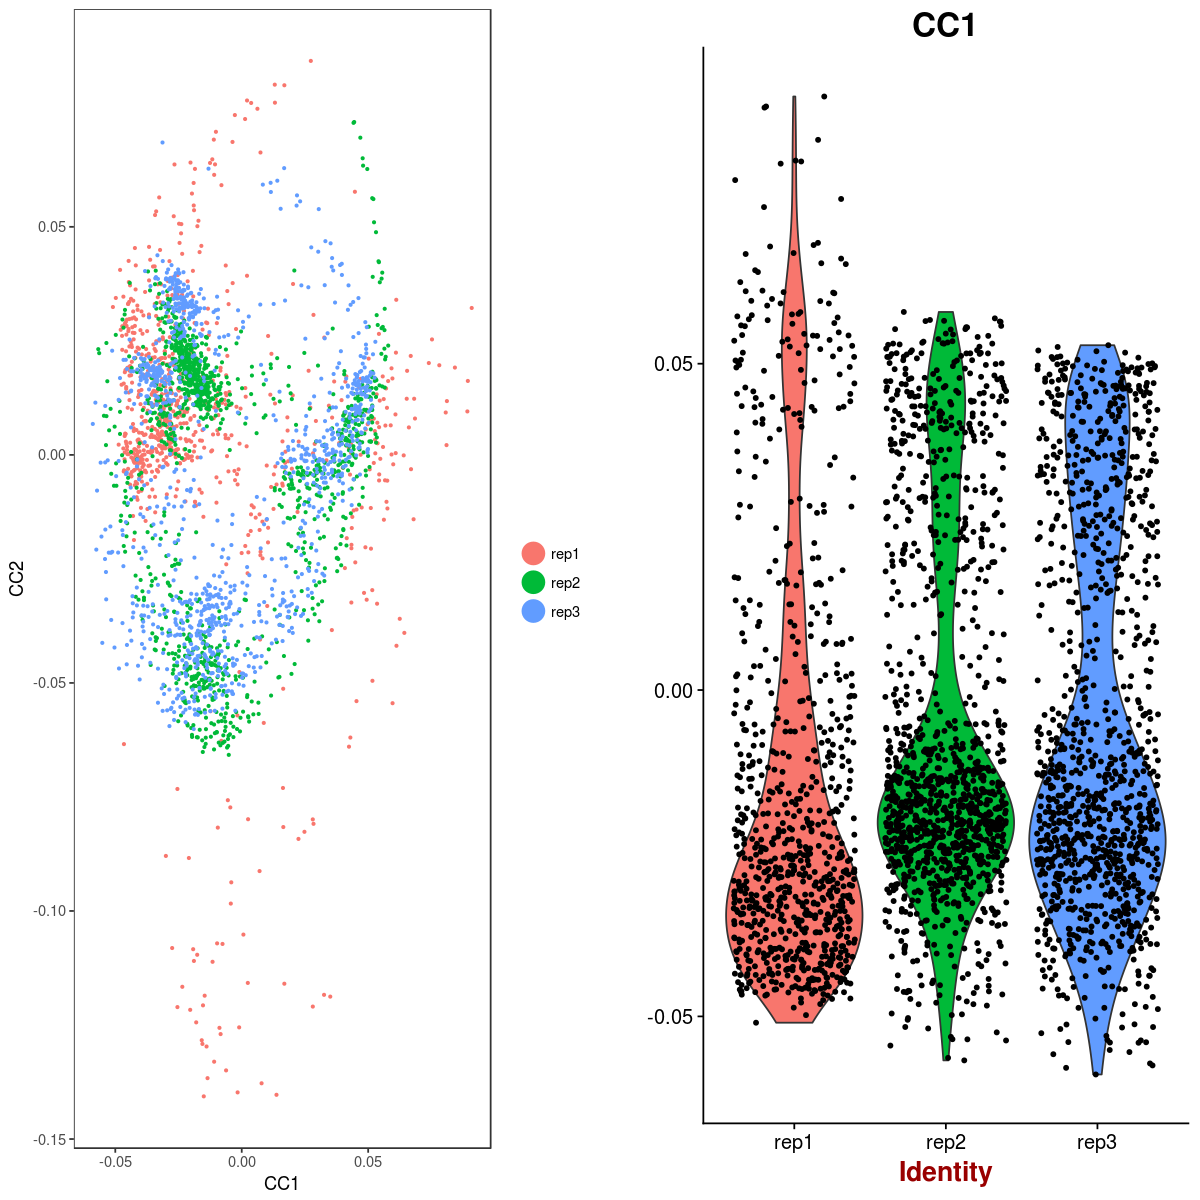

In [9]:
p1 <- DimPlot(object=combined, reduction.use='cca', group.by='rep', pt.size=0.5, do.return=TRUE)
p2 <- VlnPlot(object=combined, features.plot='CC1', group.by='rep', do.return=TRUE)
plot_grid(p1, p2)

In [10]:
combined <- AlignSubspace(combined, reduction.type = "cca", grouping.var = "rep", dims.align = 1:10)

[1] "Scaling data matrix"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%


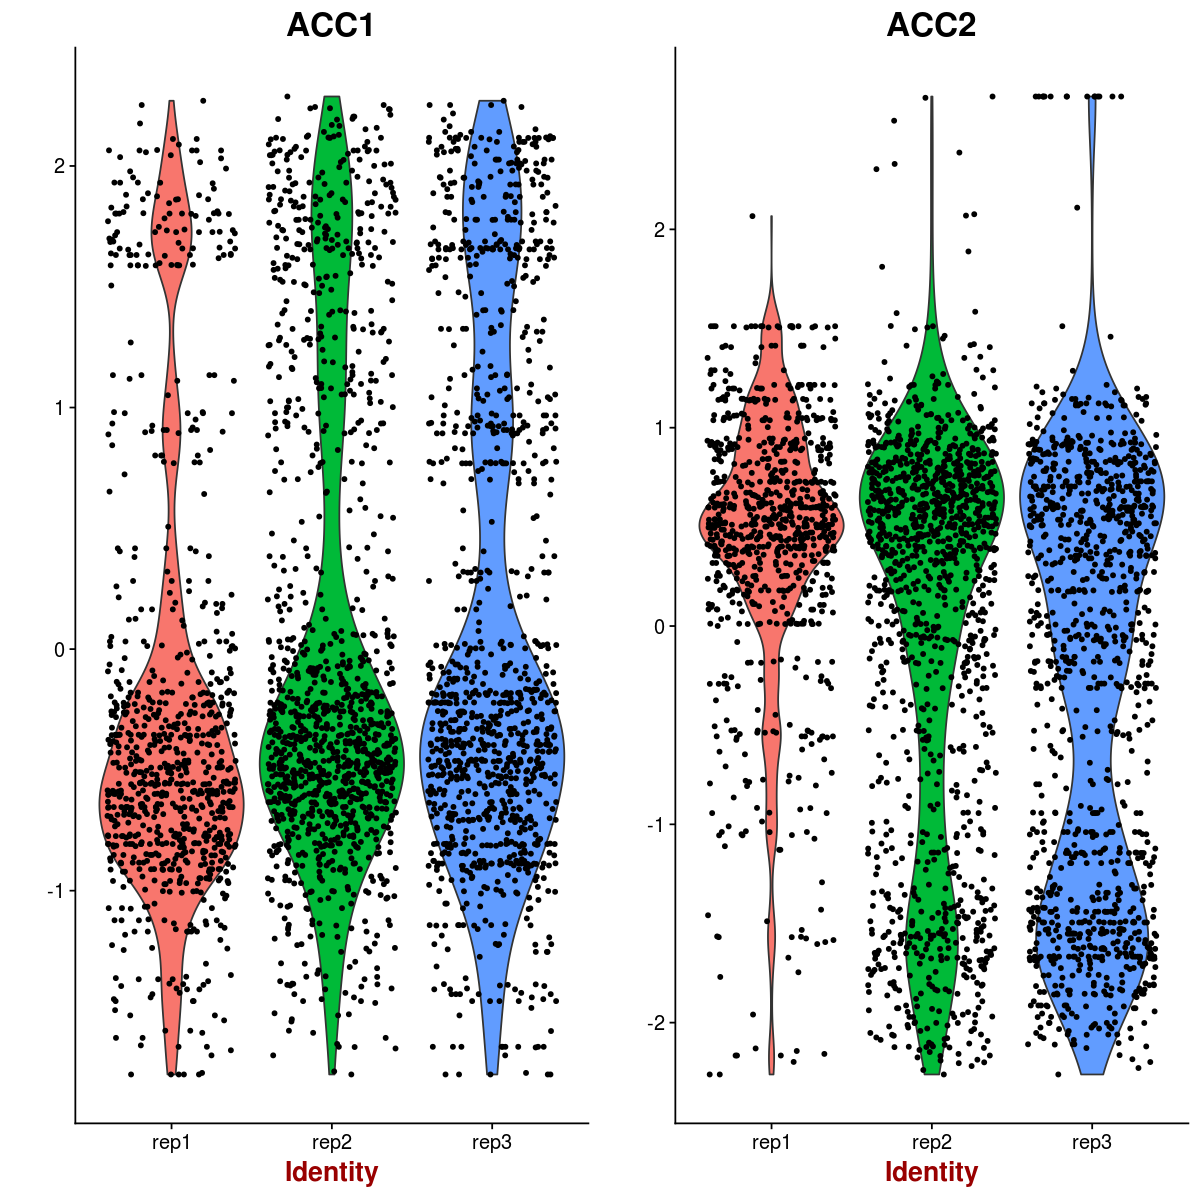

In [11]:
p1 <- VlnPlot(object=combined, features.plot='ACC1', group.by='rep', do.return=TRUE)
p2 <- VlnPlot(object=combined, features.plot='ACC2', group.by='rep', do.return=TRUE)
plot_grid(p1, p2)

In [12]:
combined <- RunTSNE(combined, reduction.use = "cca.aligned", dims.use = 1:10, do.fast = T)
combined <- FindClusters(combined, reduction.type = "cca.aligned", resolution = c(0.4, 0.6, 1.0, 1.2, 1.4), dims.use = 1:10)

[1] "Constructing SNN"
  |======================================================================| 100%


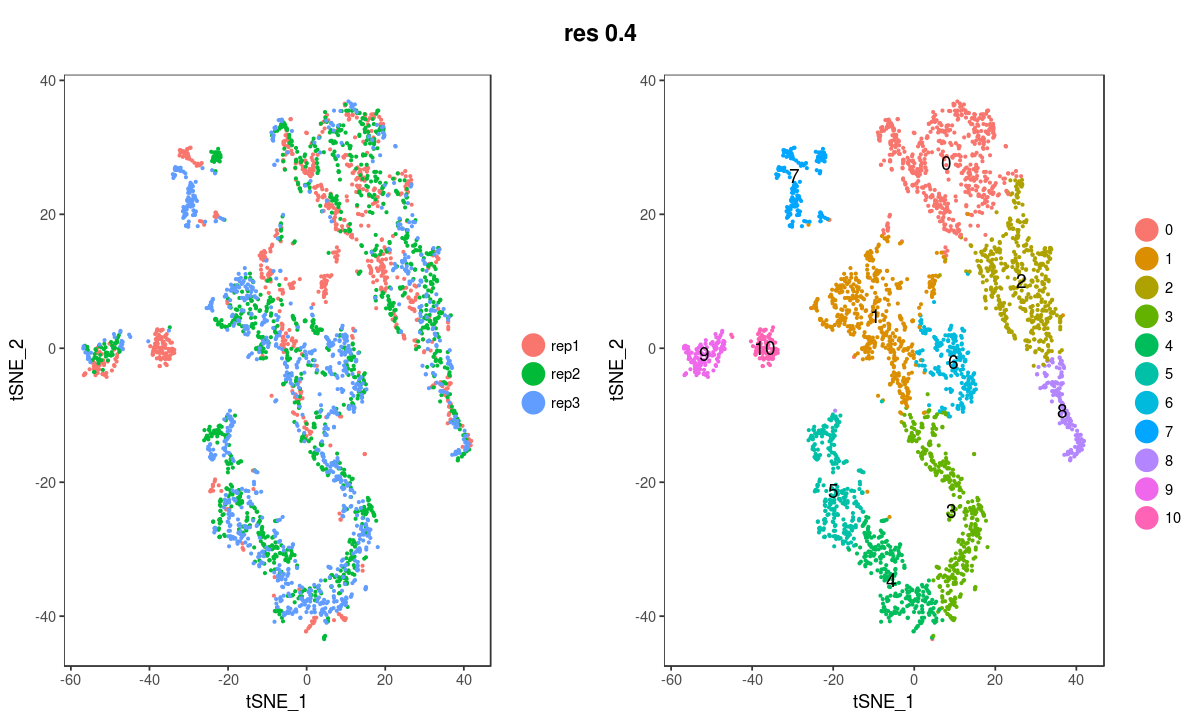

In [13]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.0.4')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 0.4", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

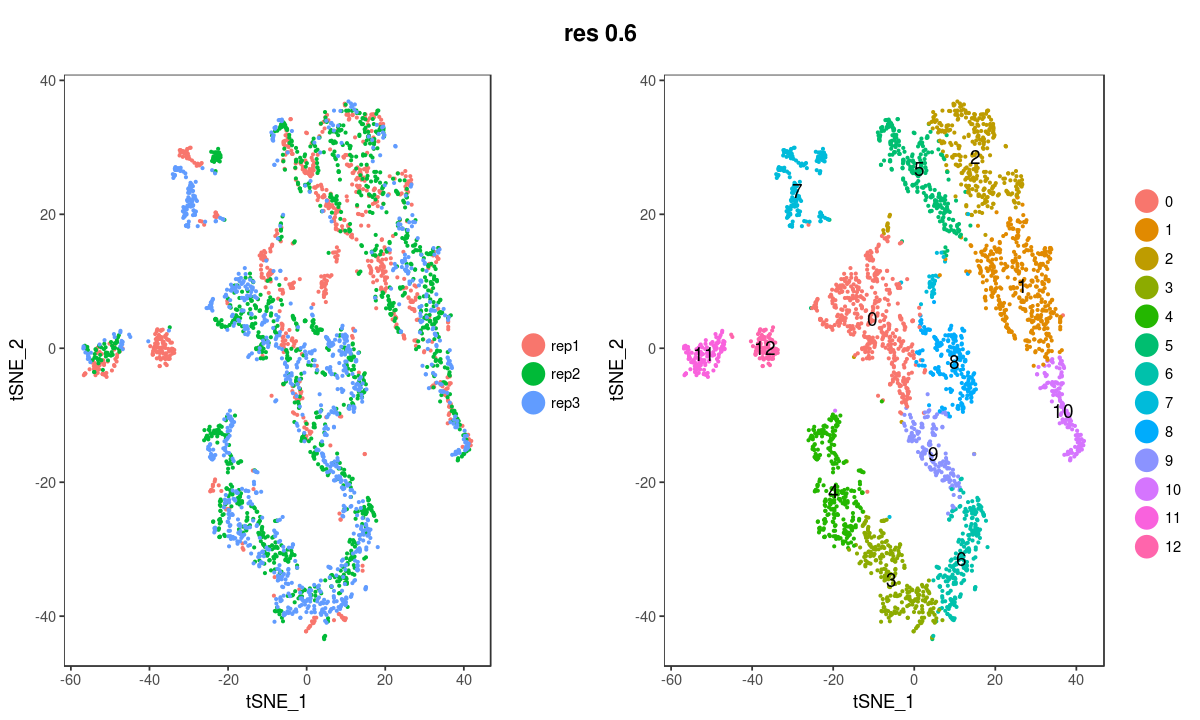

In [14]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.0.6')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 0.6", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

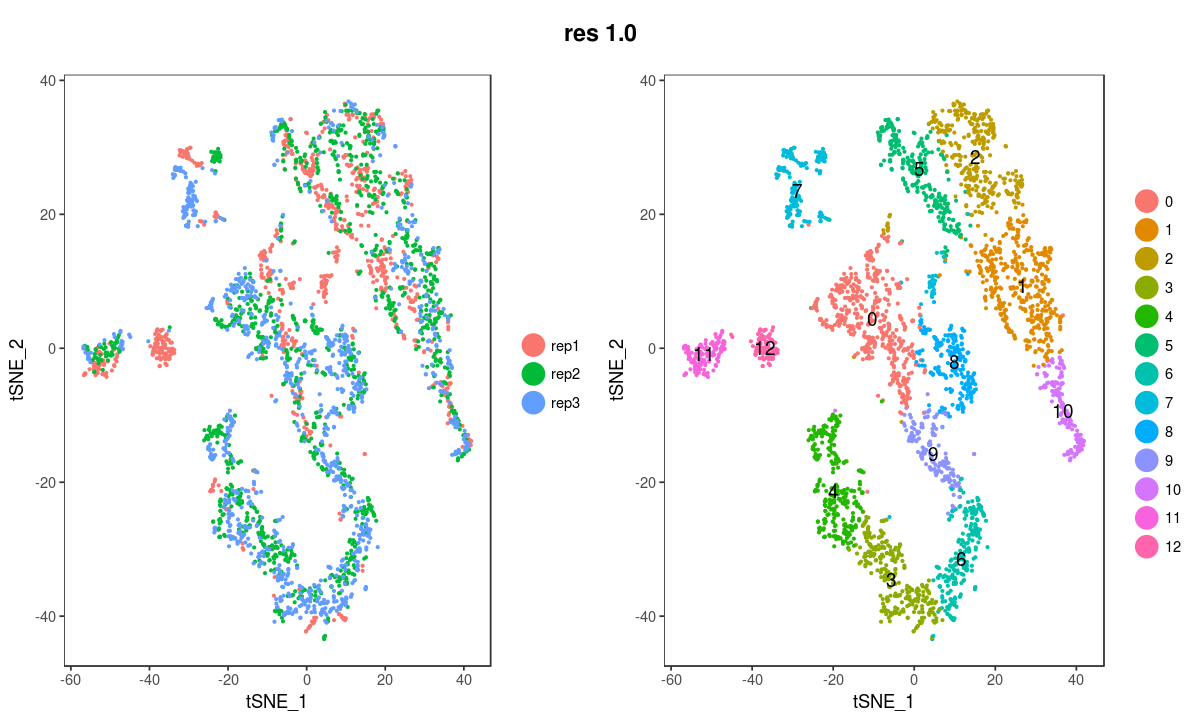

In [15]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.1.0')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 1.0", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

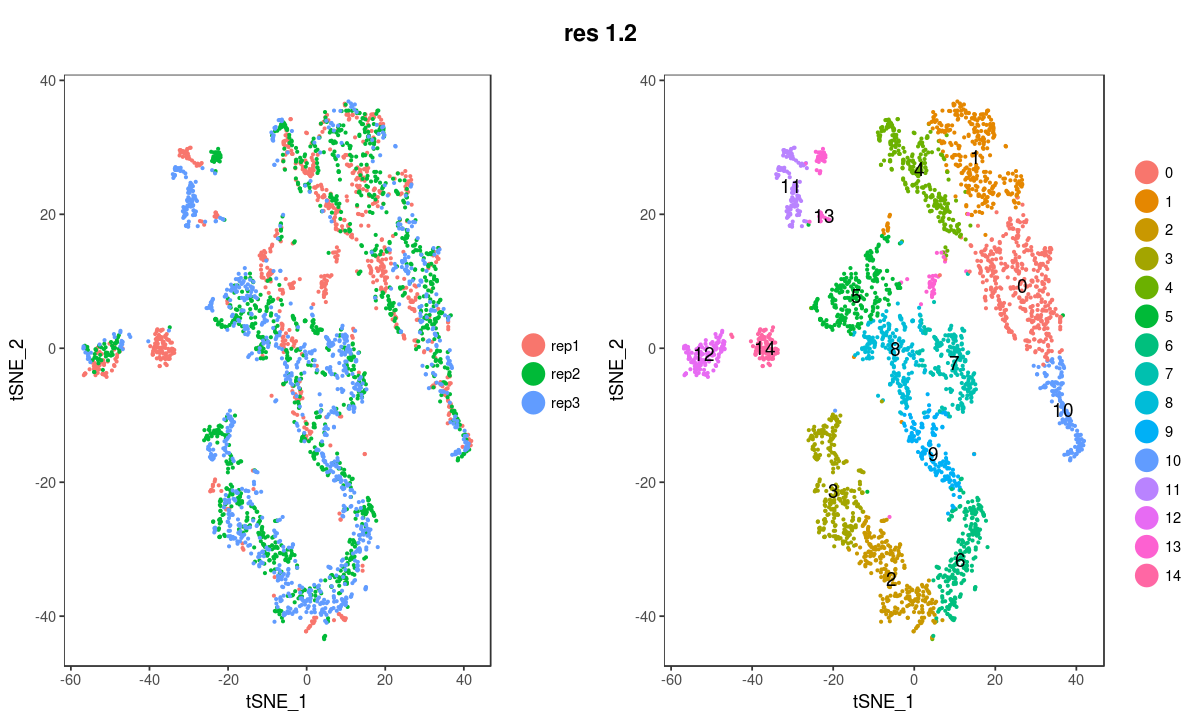

In [16]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.1.2')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 1.2", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

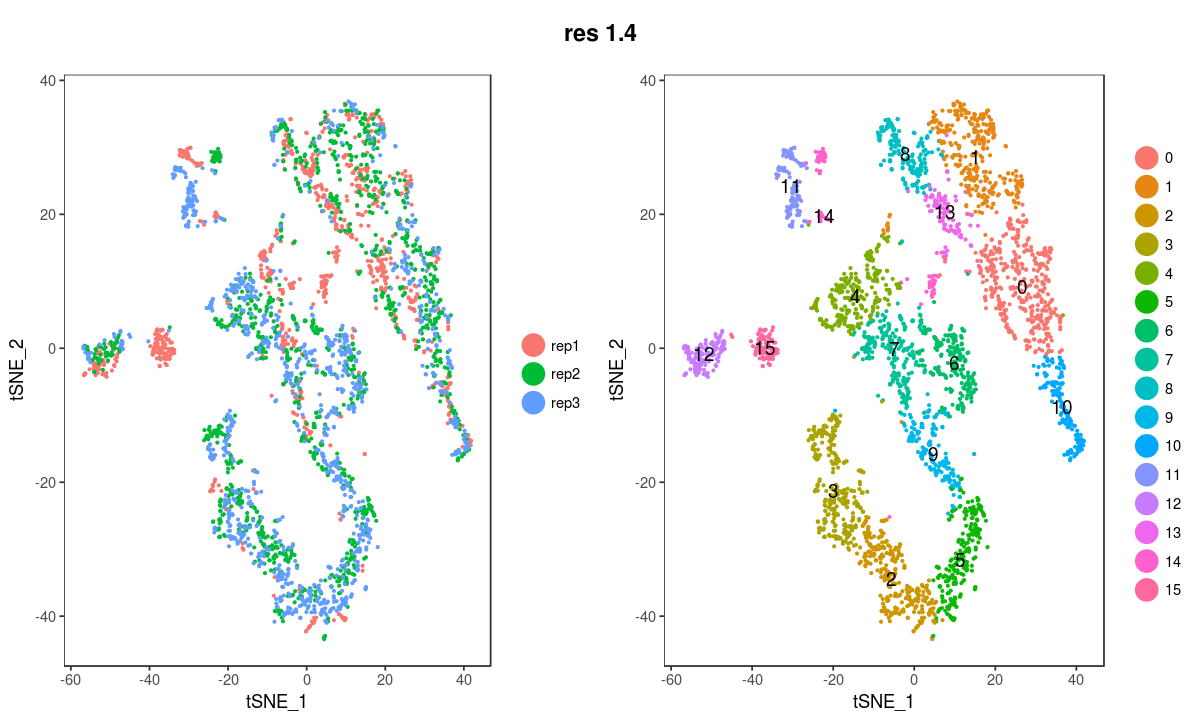

In [17]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.1.4')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 1.4", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

In [20]:
dump_seurat(object = combined, dir = OUTDIR)

In [22]:
# Save cluster info
params <- c(0.4, 0.6, 1.0, 1.2, 1.4)
params <- c(1.0, 1.2, 1.4)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    combined <- SetAllIdent(combined, id = name)
    markers <- FindAllMarkers(object = combined, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR, fname = fname)
}